<a href="https://colab.research.google.com/github/mlopes96/desafio-dio-sistema-recomendacao-por-imagens/blob/main/image_recommendation_with_tf_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image similarity search using TensorFlow Similarity

**Description:** The basis for an image recommendation system is to find the similarity between them, so for the DIO Machine Learning training challenge, on creating an image recommendation system, the TensorFlow Similarity library was used.<br>
**Example 1:** Tutorial of using similarity metric learning on CIFAR-10 images, written by [Owen Vallis](https://twitter.com/owenvallis), available on [Google Colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/metric_learning_tf_similarity.ipynb).<br>
**Example 2**: TensorFlow Similarity Supervised Learning Hello World, avaiable on [GitHub](https://github.com/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb).


## Setup

This example will use the [TensorFlow Similarity](https://github.com/tensorflow/similarity), library
to learn and evaluate the similarity embedding, version 0.15.5 and [TensorFlow](https://www.tensorflow.org/overview) version 2.8.0.

In [2]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 58.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [3]:
!pip install tensorflow_similarity==0.15.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13547980 sha256=87309a67b2369950b98e1321e982ac1733c0f8ba13ea58d610798169848f19bf
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=d1726b52cb69c1c6c26c05387eb27e6fcc313c4ca114a2040191989ec252ccea
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784

In [4]:
# Load the libraries
import random
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_similarity as tfsim

tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity: 0.15.5


## Dataset samplers

We will be using the
[CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10)
dataset for this example.

For a similarity model to learn efficiently, each batch must contains at least 2 examples of each class.

To make this easy, tf_similarity offers `Sampler` objects that enable you to set both
the number of classes and the minimum number of examples of each class per
batch.

We also create a validation dataset in the same way, but we limit the total number of
examples per class to 100 and the examples per class per batch is set to the default of 2.

In [5]:
# This determines the number of classes used during training.
# Here we are using all the classes.
num_known_classes = 10
class_list = random.sample(population=range(10), k=num_known_classes)

classes_per_batch = 10
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. This can be useful when performing triplet mining or
# when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can
# take a weighted mix of all the positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. However,
# the losses compute the pairwise distance between the examples in a batch so
# the upper limit of the batch size is restricted by the memory.
examples_per_class_per_batch = 8

print(
    "Batch size is: "
    f"{min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}"
)

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=min(classes_per_batch, num_known_classes),
    splits="train",
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list,
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=classes_per_batch,
    splits="test",
    total_examples_per_class=100,
)

Batch size is: 80
###### Create Training Data ######


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE277Y3/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE277Y3/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


converting train:   0%|          | 0/50000 [00:00<?, ?it/s]


The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50000 [00:00<?, ?it/s]


##### Create Validation Data #####


converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1000 [00:00<?, ?it/s]

## Visualize the dataset

The samplers will shuffle the dataset, so we can get a sense of the dataset by
plotting the first 25 images.

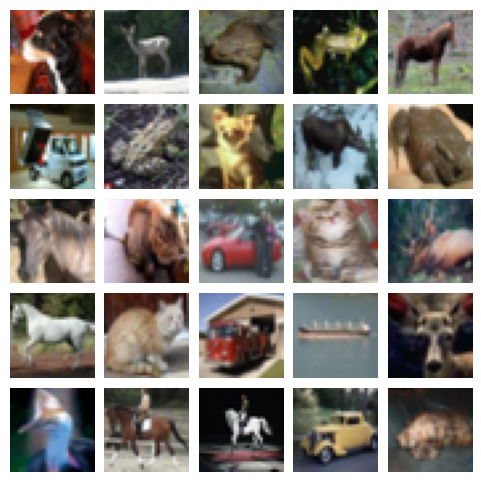

In [6]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

## Embedding model

Next we define a `SimilarityModel` using the Keras Functional API. The model
is a standard convnet with the addition of a `MetricEmbedding` layer that
applies L2 normalization. The metric embedding layer is helpful when using
`Cosine` distance as we only care about the angle between the vectors.

In [7]:
embedding_size = 256

inputs = keras.layers.Input((32, 32, 3))
x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

# building model
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                  

## Similarity loss

The similarity loss expects batches containing at least 2 examples of each
class, from which it computes the loss over the pairwise positive and negative
distances. Here we are using `MultiSimilarityLoss()`
([paper](ihttps://arxiv.org/abs/1904.06627)), one of several losses in
[TensorFlow Similarity](https://github.com/tensorflow/similarity). This loss
attempts to use all informative pairs in the batch, taking into account the
self-similarity, positive-similarity, and the negative-similarity.

In [8]:
epochs = 3
learning_rate = 0.002
val_steps = 50

# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss()

# compiling and training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10,
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/3
4000/4000 [==============================] - 73s 18ms/step - loss: 2.2191 - val_loss: 0.8980
Warmup complete
Epoch 2/3
4000/4000 [==============================] - 62s 15ms/step - loss: 1.8990 - val_loss: 0.8613
Epoch 3/3
4000/4000 [==============================] - 62s 16ms/step - loss: 1.6138 - val_loss: 0.8156


## Indexing

Now that we have trained our model, we can create an index of examples. Here we
batch index the first 200 validation examples by passing the x and y to the index
along with storing the image in the data parameter. The `x_index` values are
embedded and then added to the index to make them searchable. The `y_index` and
data parameters are optional but allow the user to associate metadata with the
embedded example.

In [9]:
x_index, y_index = val_ds.get_slice(begin=0, size=200)
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


## Calibration

Once the index is built, we can calibrate a distance threshold using a matching
strategy and a calibration metric.

Here we are searching for the optimal F1 score while using K=1 as our
classifier. All matches at or below the calibrated threshold distance will be
labeled as a Positive match between the query example and the label associated
with the match result, while all matches above the threshold distance will be
labeled as a Negative match.

Additionally, we pass in extra metrics to compute as well. All values in the
output are computed at the calibrated threshold.

In [10]:
x_train, y_train = train_ds.get_slice(begin=0, size=1000)
calibration = model.calibrate(
    x_train,
    y_train,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/982 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal     0.94   0.0553487        0.878         1              0.878  0.935037


## Visualization

It may be difficult to get a sense of the model quality from the metrics alone.
A complementary approach is to manually inspect a set of query results to get a
feel for the match quality.

Here we take 10 validation examples and plot them with their 5 nearest
neighbors and the distances to the query example. Looking at the results, we see
that while they are imperfect they still represent meaningfully similar images,
and that the model is able to find similar images irrespective of their pose or
image illumination.

We can also see that the model is very confident with certain images, resulting
in very small distances between the query and the neighbors. Conversely, we see
more mistakes in the class labels as the distances become larger. This is one of
the reasons why calibration is critical for matching applications.


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

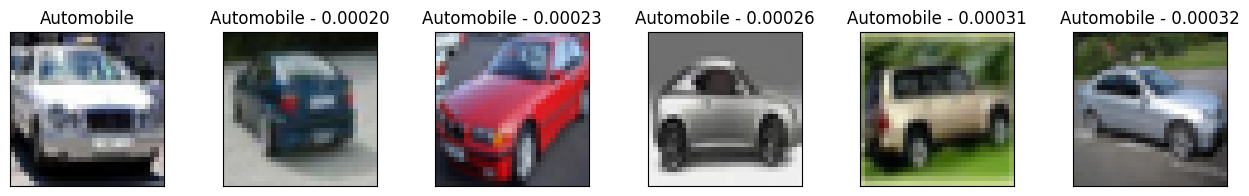

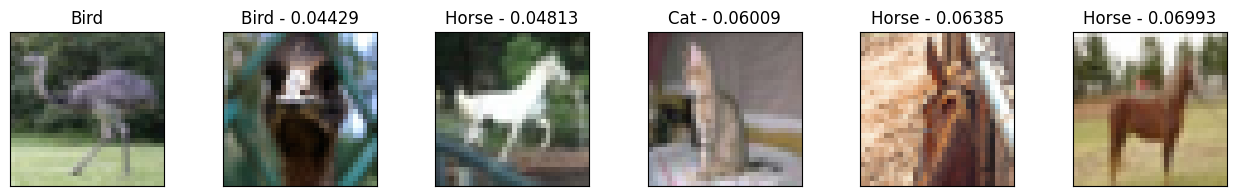

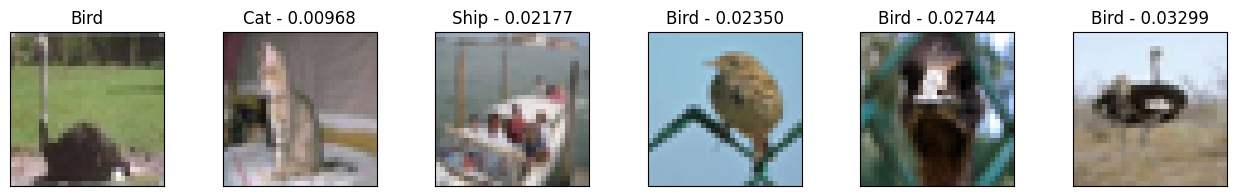

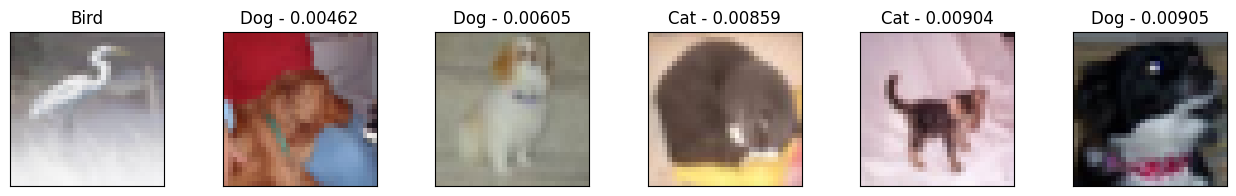

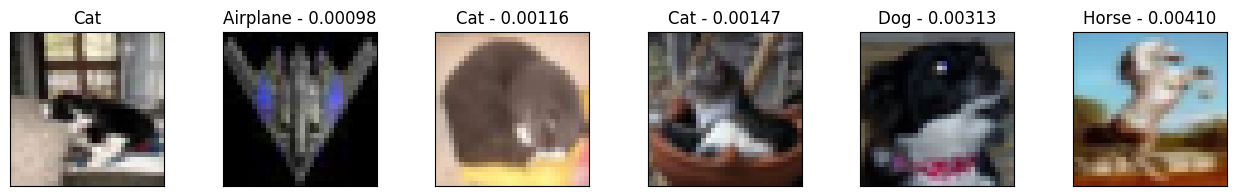

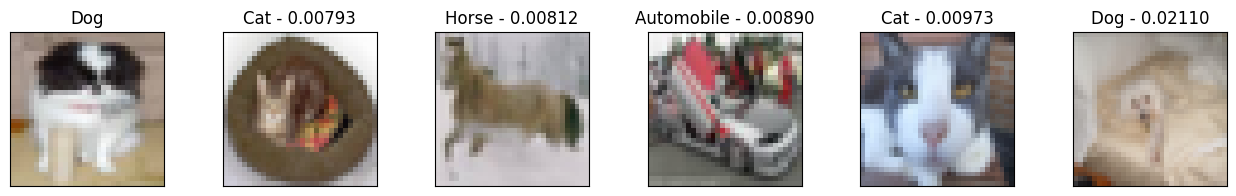

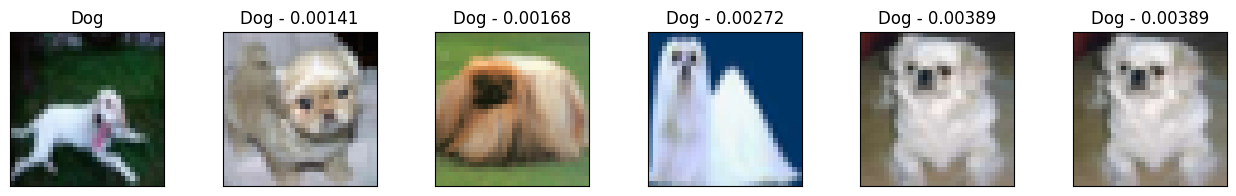

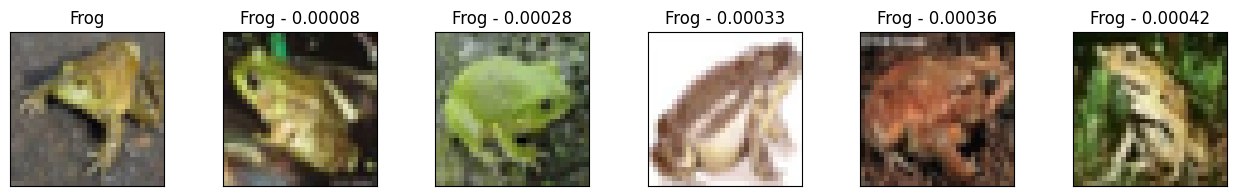

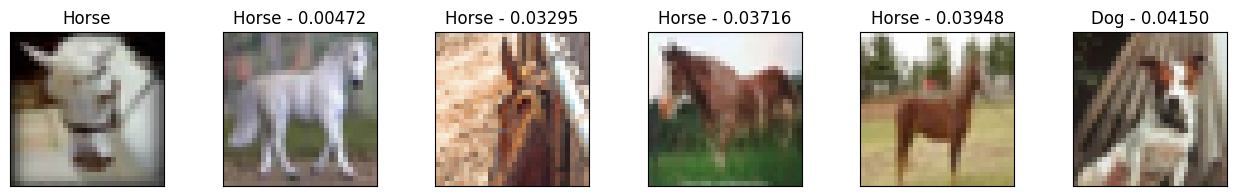

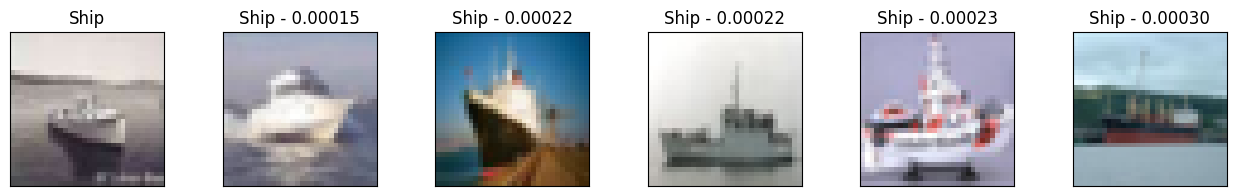

In [11]:
num_neighbors = 5
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
    "Unknown",
]
class_mapping = {c_id: c_lbl for c_id, c_lbl in zip(range(11), labels)}

# select
x_display, y_display = val_ds.get_slice(begin=200, size=10)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(
        x_display[idx],
        y_display[idx],
        nns[idx],
        class_mapping=class_mapping,
        fig_size=(16, 2),
    )

## Metrics

We can also plot the extra metrics contained in the `CalibrationResults` to get
a sense of the matching performance as the distance threshold increases.

The following plots show the Precision, Recall, and F1 Score. We can see that
the matching precision degrades as the distance increases, but that the
percentage of the queries that we accept as positive matches (recall) grows
faster up to the calibrated distance threshold.

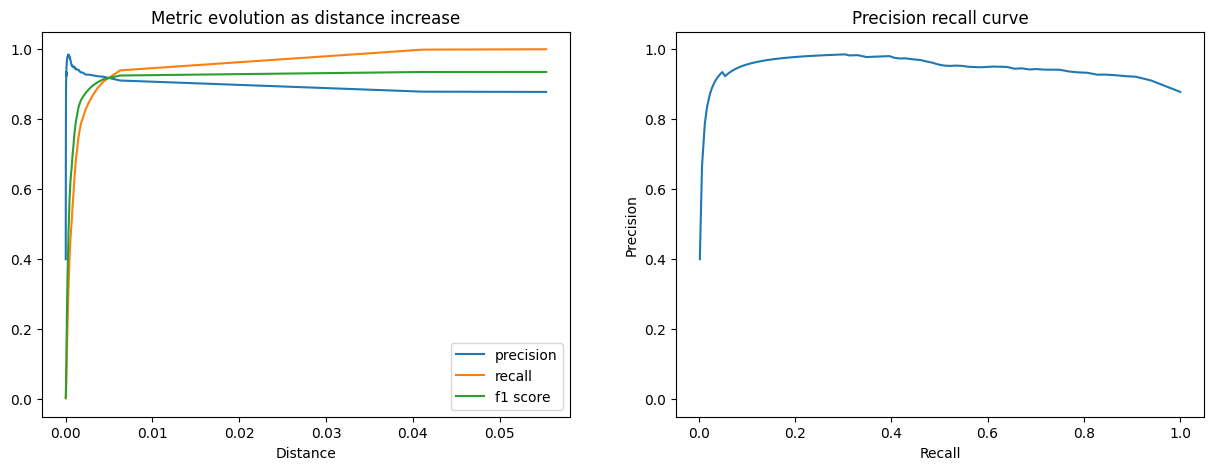

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = calibration.thresholds["distance"]

ax1.plot(x, calibration.thresholds["precision"], label="precision")
ax1.plot(x, calibration.thresholds["recall"], label="recall")
ax1.plot(x, calibration.thresholds["f1"], label="f1 score")
ax1.legend()
ax1.set_title("Metric evolution as distance increase")
ax1.set_xlabel("Distance")
ax1.set_ylim((-0.05, 1.05))

ax2.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax2.set_title("Precision recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_ylim((-0.05, 1.05))
plt.show()

We can also take 100 examples for each class and plot the confusion matrix for
each example and their nearest match. We also add an "extra" 10th class to
represent the matches above the calibrated distance threshold.

We can see that most of the errors are between the animal classes with an
interesting number of confusions between Airplane and Bird. Additionally, we see
that only a few of the 100 examples for each class returned matches outside of
the calibrated distance threshold.

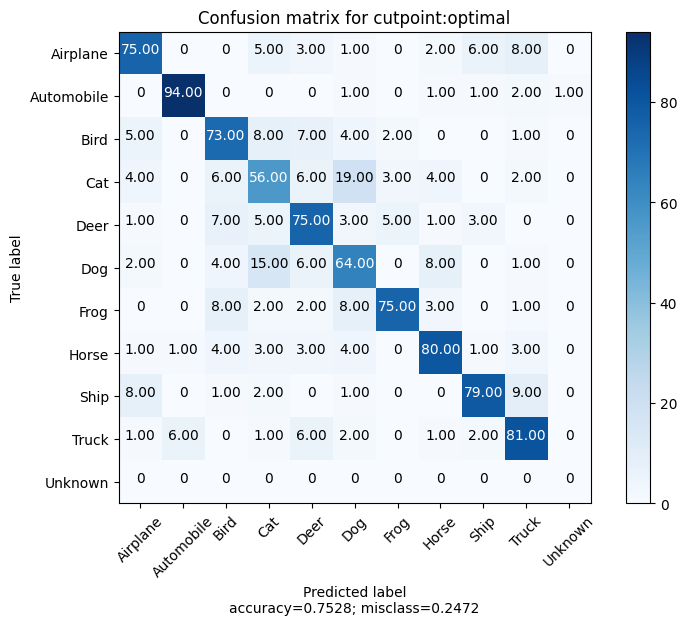

In [13]:
cutpoint = "optimal"

# This yields 100 examples for each class.
# We defined this when we created the val_ds sampler.
x_confusion, y_confusion = val_ds.get_slice(0, -1)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusion matrix for cutpoint:%s" % cutpoint,
    normalize=False,
)